## Topic Modeling - By Subreddit

By Shwetha Srinivasan

Lines of code: 206

This notebook analyses the distribution of topics using the LDA model for each of the 5 selected subreddits: canada, australia, the donald, futurology and collapse. The topic distribution is visualized through graphs by year as well as year and month. Visuals are based on frequency of topics in a given period as well as relative frequency of topics.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from sklearn.decomposition import LatentDirichletAllocation as LDA
from nltk.corpus import stopwords

import gensim
from gensim import corpora
from nltk.tokenize import word_tokenize
import regex as re
import spacy


In [2]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

In [3]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [4]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
path_gdrive = '/content/drive/Shareddrives/adv-ml-project/Data'

In [6]:
df_category = pd.read_csv(path_gdrive + '/' + 'by_category/comments_filtered.csv')

In [ ]:
df_category.head()

,subreddit.name,date,body,sentiment,label
0,futurology,2022-08-31 23:53:39,Blaming environmentalists for the failure of n...,0.3094,1.0
1,canada,2022-08-31 23:27:11,"['Pipelines will be blown up,' says David Suzu...",-0.9719,0.0
2,australia,2022-08-31 23:19:53,\n&gt;You don't want there to be any actual ac...,-0.8434,0.0
3,collapse,2022-08-31 23:17:48,&gt; Sounds like we have 20 years\n\nWhy lie a...,-0.6249,0.0
4,canada,2022-08-31 23:14:46,I'm not running from anything.\n\nI haven't ex...,0.7942,1.0


In [ ]:
df_category.shape

(307041, 5)

In [8]:
df_category['subreddit.name'].unique()

array(['futurology', 'canada', 'australia', 'collapse', 'the_donald'],
      dtype=object)

In [8]:
df_canada = df_category[df_category['subreddit.name'] == 'canada']
df_canada.shape

(59037, 5)

In [9]:
df_australia = df_category[df_category['subreddit.name'] == 'australia']
df_australia.shape

(46267, 5)

In [7]:
df_futurology = df_category[df_category['subreddit.name'] == 'futurology']
df_futurology.shape

(83235, 5)

In [11]:
df_collapse = df_category[df_category['subreddit.name'] == 'collapse']
df_collapse.shape

(88010, 5)

In [12]:
df_donald = df_category[df_category['subreddit.name'] == 'the_donald']
df_donald.shape

(30492, 5)

In [13]:
def analyze_topics_over_time(df, text_column, date_column, num_topics=10, passes=15, topn_words=5):
    # Tokenize and preprocess the documents
    df = df.sample(frac=0.05, random_state=42)
    stop_words = set(stopwords.words('english'))
    tokenized_documents = [word_tokenize(doc.lower()) for doc in df[text_column].tolist()]
    filtered_documents = [
        [word for word in doc if word.isalnum() and word not in stop_words and not re.match(r'https?://\S+|www\.\S+|http\S+', word)]
        for doc in tokenized_documents
    ]

    # Create a dictionary and corpus
    dictionary = corpora.Dictionary(filtered_documents)
    corpus = [dictionary.doc2bow(doc) for doc in filtered_documents]

    # Build the LDA model
    lda_model = gensim.models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=passes, random_state=42)

    # Find dominant topics and their top words
    dominant_topics = []
    for doc_bow in corpus:
        doc_topics = lda_model.get_document_topics(doc_bow, minimum_probability=0.0)
        dominant_topic = sorted(doc_topics, key=lambda x: x[1], reverse=True)[0][0]
        top_words = [word for word, prob in lda_model.show_topic(dominant_topic, topn=topn_words)]
        top_words_str = ", ".join(top_words)
        topic_and_words = f"Topic {dominant_topic}: {top_words_str}"
        dominant_topics.append(topic_and_words)

    df['dominant_topic'] = dominant_topics
    df[date_column] = pd.to_datetime(df[date_column])
    df.set_index(date_column, inplace=True)

    topic_counts_by_year = df.groupby([pd.Grouper(freq='Y'), 'dominant_topic']).size().unstack(fill_value=0)
    sns.set_theme(style="whitegrid")
    palette = sns.color_palette("husl", len(topic_counts_by_year.columns))

    plt.figure(figsize=(14, 7))
    for idx, topic in enumerate(topic_counts_by_year.columns):
        plt.plot(topic_counts_by_year.index.year, topic_counts_by_year[topic], marker='o', linewidth=2, markersize=8, label=f'{topic}', color=palette[idx])

    plt.title('Dominant Topics Over Time', fontsize=16)
    plt.xlabel('Year', fontsize=14)
    plt.ylabel('Frequency of Dominant Topic', fontsize=14)
    plt.legend(title='Dominant Topic', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
    plt.xticks(topic_counts_by_year.index.year[::2], rotation=45)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()






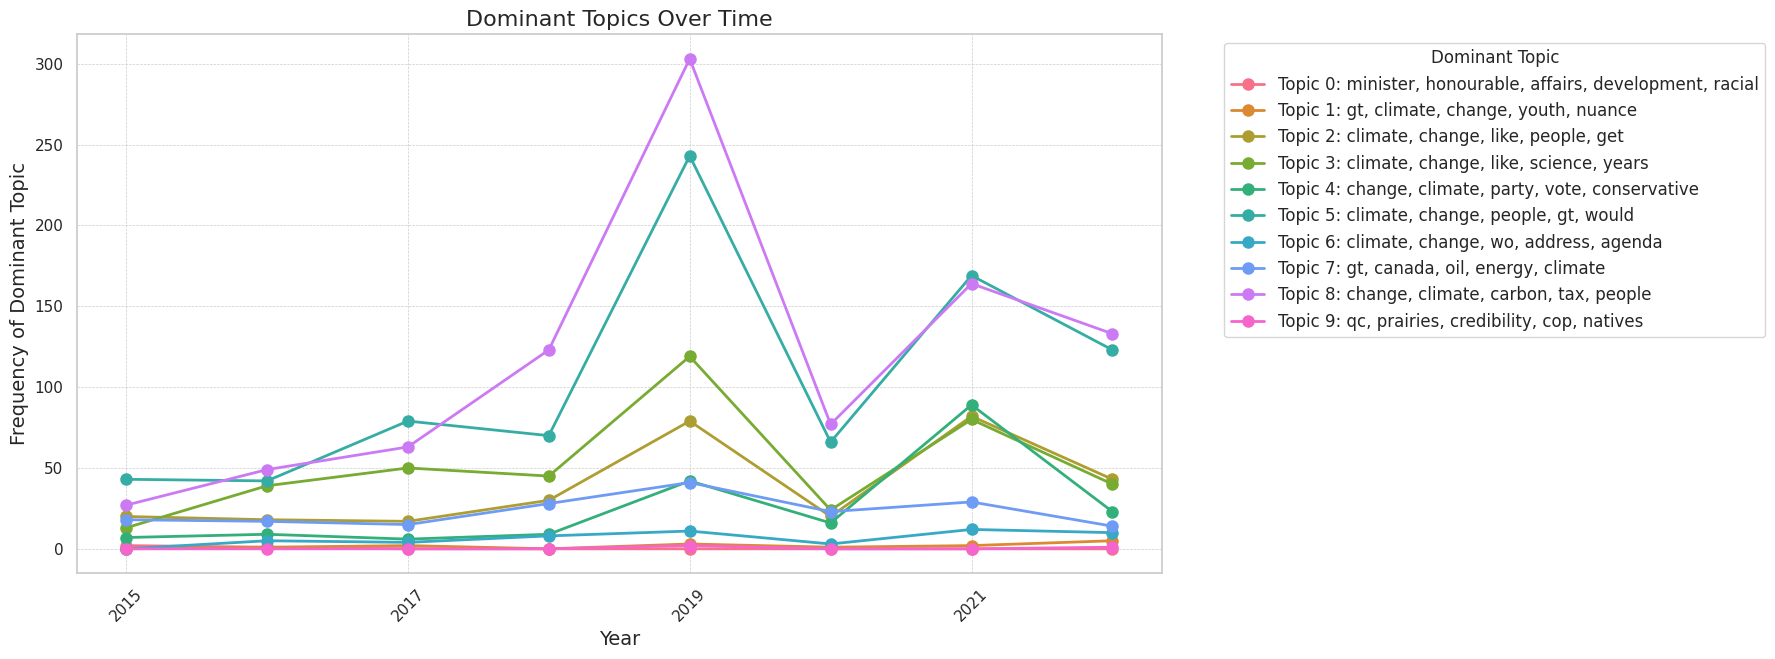

In [15]:
analyze_topics_over_time(df_canada, 'body', 'date', num_topics=10, passes=15, topn_words=5)

In [14]:
def analyze_topics_over_time_normalized(df, text_column, date_column, num_topics=10, passes=15, topn_words=5):
    # Tokenize and preprocess the documents
    df = df.sample(frac=0.05, random_state=42)
    stop_words = set(stopwords.words('english'))
    tokenized_documents = [word_tokenize(doc.lower()) for doc in df[text_column].tolist()]
    filtered_documents = [
        [word for word in doc if word.isalnum() and word not in stop_words and not re.match(r'https?://\S+|www\.\S+|http\S+', word)]
        for doc in tokenized_documents
    ]

    # Create a dictionary and corpus
    dictionary = corpora.Dictionary(filtered_documents)
    corpus = [dictionary.doc2bow(doc) for doc in filtered_documents]

    # Build the LDA model
    lda_model = gensim.models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=passes, random_state=42)

    # Find dominant topics and their top words
    dominant_topics = []
    for doc_bow in corpus:
        doc_topics = lda_model.get_document_topics(doc_bow, minimum_probability=0.0)
        dominant_topic = sorted(doc_topics, key=lambda x: x[1], reverse=True)[0][0]
        top_words = [word for word, prob in lda_model.show_topic(dominant_topic, topn=topn_words)]
        top_words_str = ", ".join(top_words)
        topic_and_words = f"Topic {dominant_topic}: {top_words_str}"
        dominant_topics.append(topic_and_words)

    df['dominant_topic'] = dominant_topics
    df[date_column] = pd.to_datetime(df[date_column])
    df.set_index(date_column, inplace=True)

    # Resample and plot
    topic_counts_by_year = df.groupby([pd.Grouper(freq='Y'), 'dominant_topic']).size().unstack(fill_value=0)
    normalized_topic_counts = topic_counts_by_year.div(topic_counts_by_year.sum(axis=1), axis=0)

    # Plot the normalized frequencies
    sns.set_theme(style="whitegrid")
    palette = sns.color_palette("husl", len(normalized_topic_counts.columns))

    plt.figure(figsize=(14, 7))
    for idx, topic in enumerate(normalized_topic_counts.columns):
        plt.plot(normalized_topic_counts.index.year, normalized_topic_counts[topic], marker='o', linewidth=2, markersize=8, label=f'{topic}', color=palette[idx])

    plt.title('Normalized Dominant Topics Over Time', fontsize=16)
    plt.xlabel('Year', fontsize=14)
    plt.ylabel('Relative Frequency of Dominant Topic', fontsize=14)
    plt.legend(title='Dominant Topic', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
    plt.xticks(normalized_topic_counts.index.year[::2], rotation=45)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()

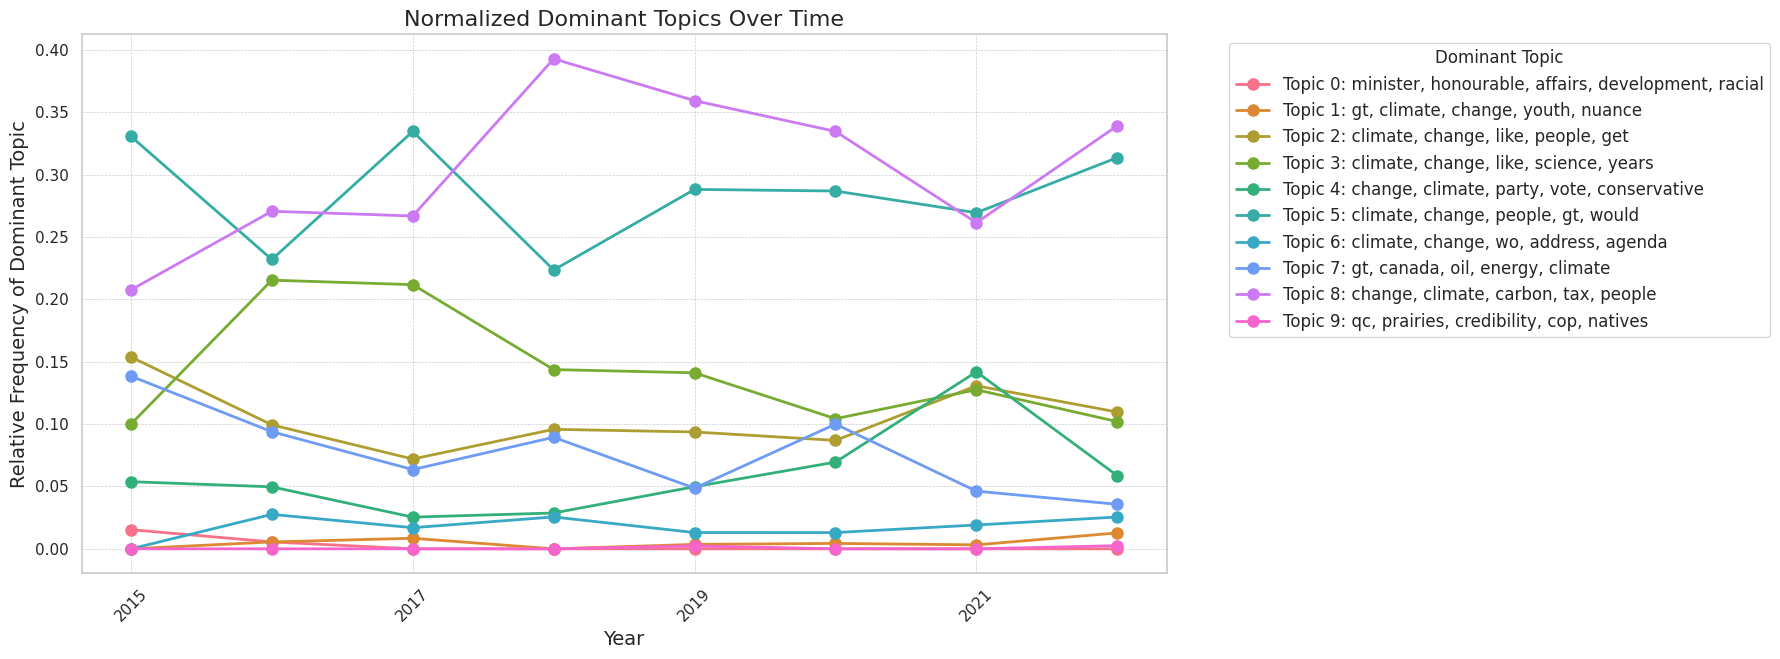

In [17]:
analyze_topics_over_time_normalized(df_canada, 'body', 'date', num_topics=10, passes=15, topn_words=5)

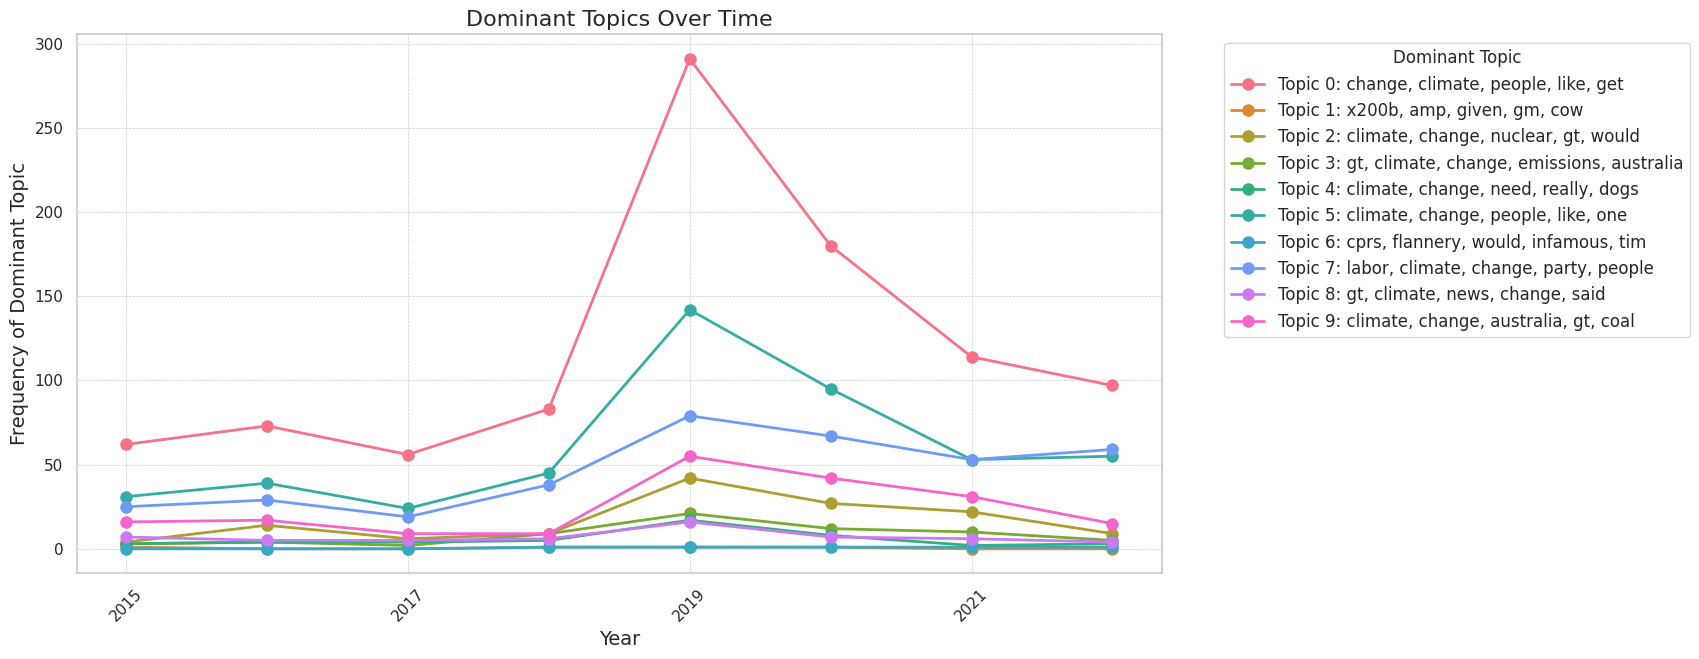

In [ ]:
analyze_topics_over_time(df_australia, 'body', 'date', num_topics=10, passes=15, topn_words=5)

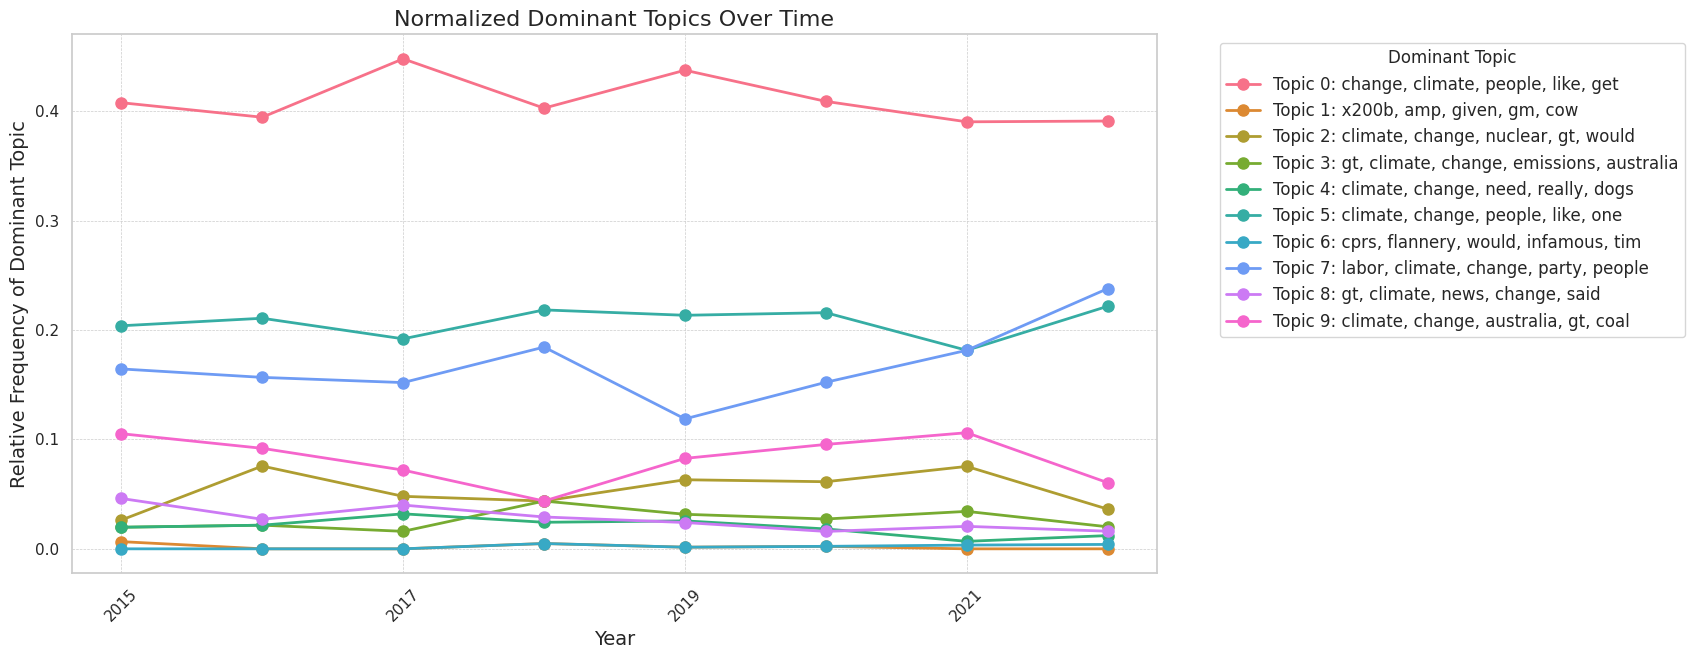

In [18]:
analyze_topics_over_time_normalized(df_australia, 'body', 'date', num_topics=10, passes=15, topn_words=5)

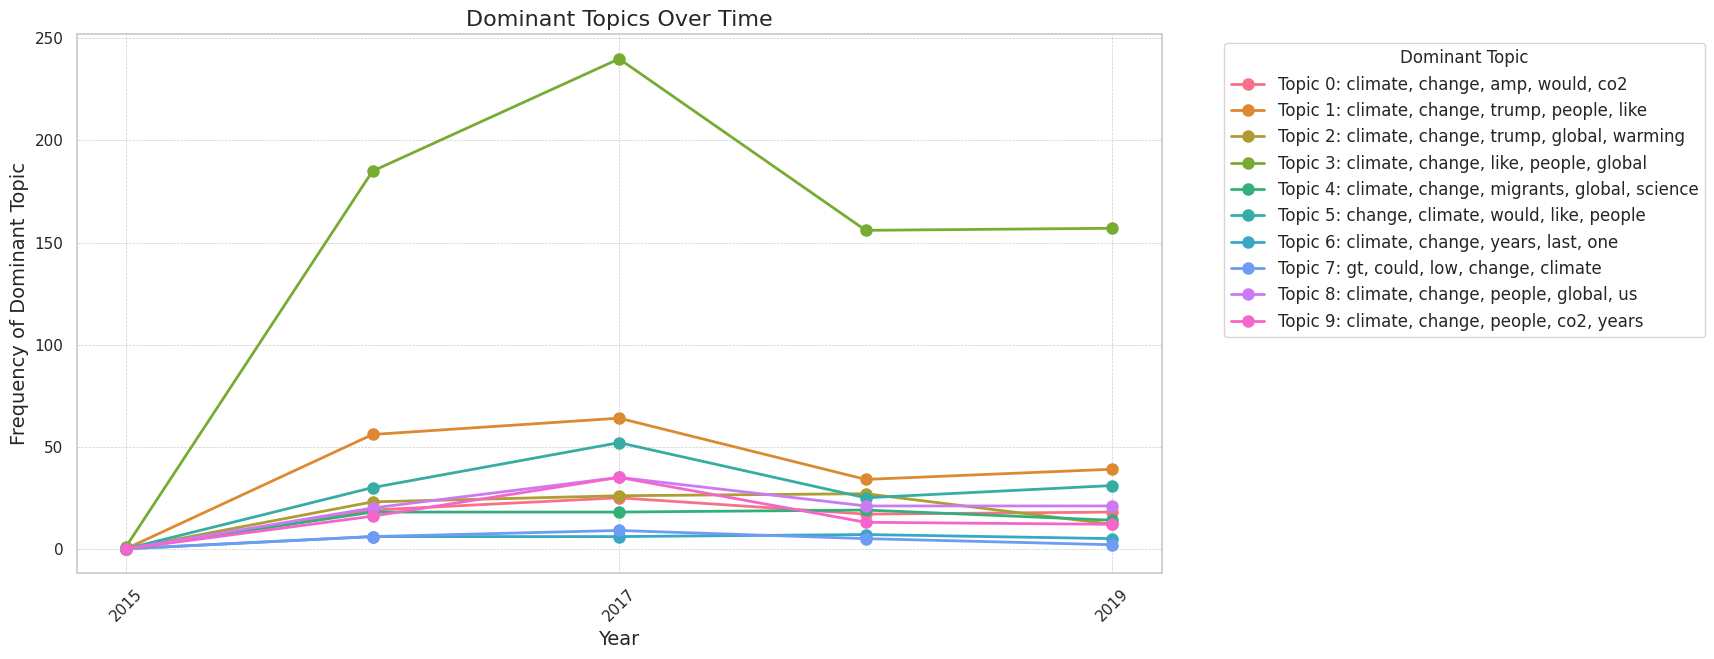

In [ ]:
analyze_topics_over_time(df_donald, 'body', 'date', num_topics=10, passes=15, topn_words=5)

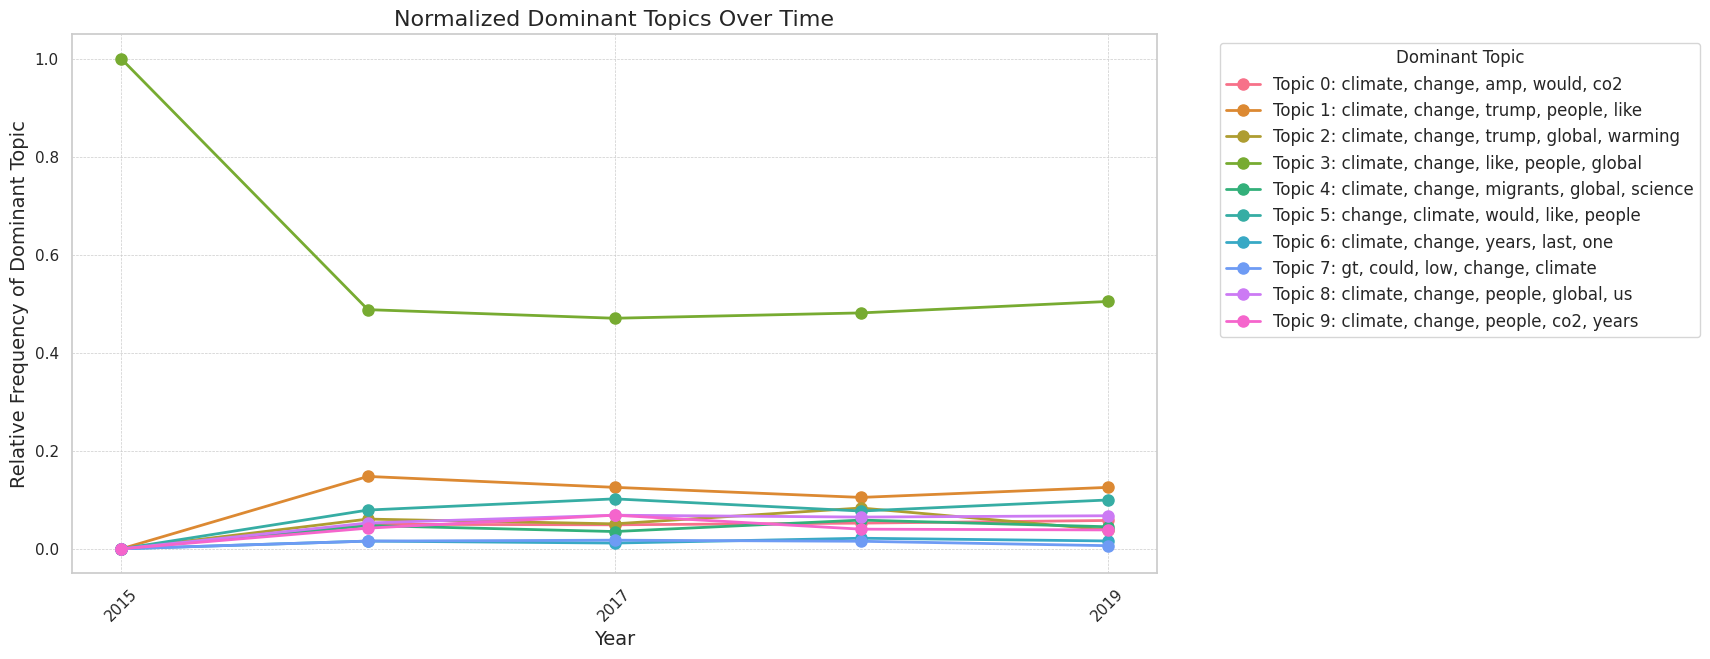

In [19]:
analyze_topics_over_time_normalized(df_donald, 'body', 'date', num_topics=10, passes=15, topn_words=5)

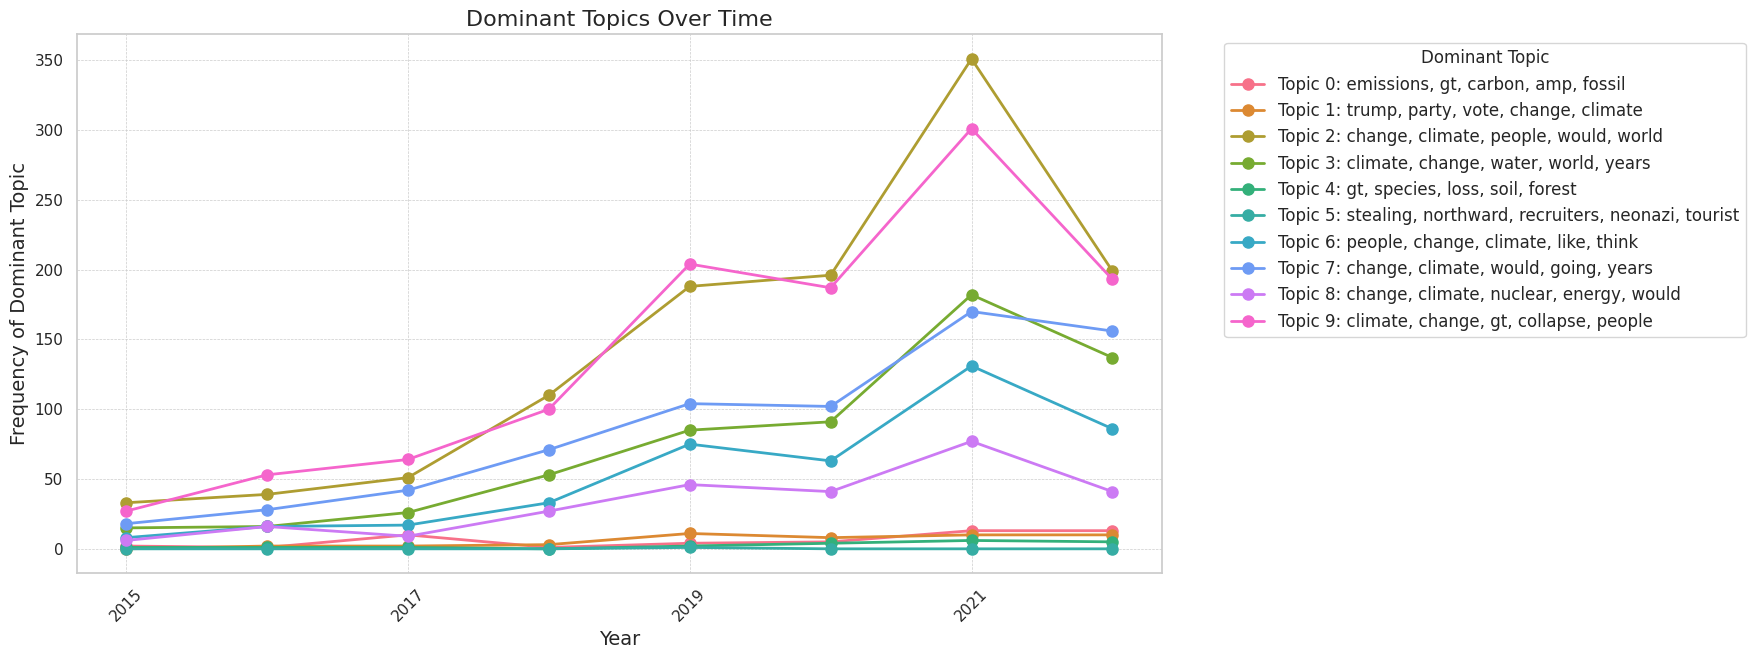

In [ ]:
analyze_topics_over_time(df_collapse, 'body', 'date', num_topics=10, passes=15, topn_words=5)

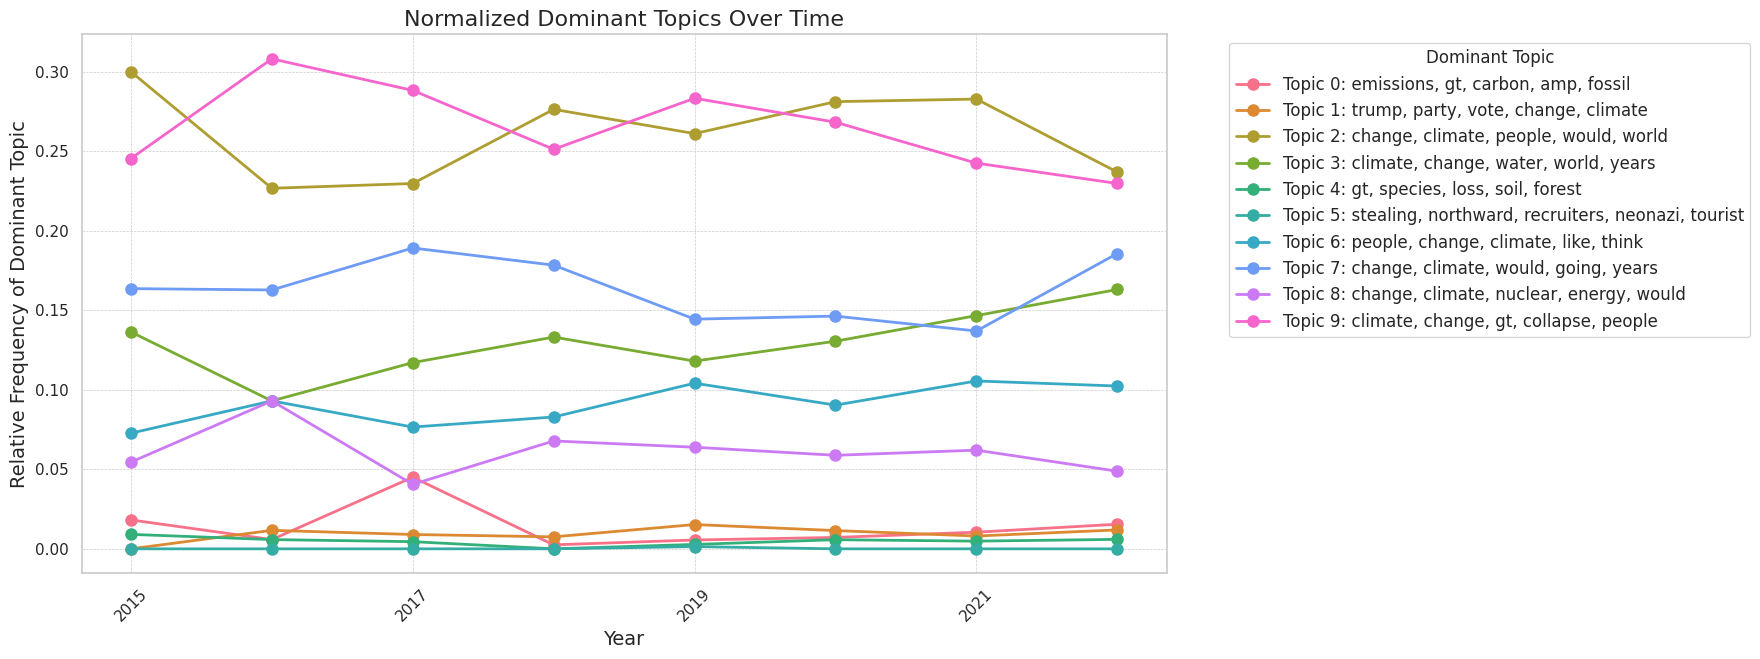

In [20]:
analyze_topics_over_time_normalized(df_collapse, 'body', 'date', num_topics=10, passes=15, topn_words=5)

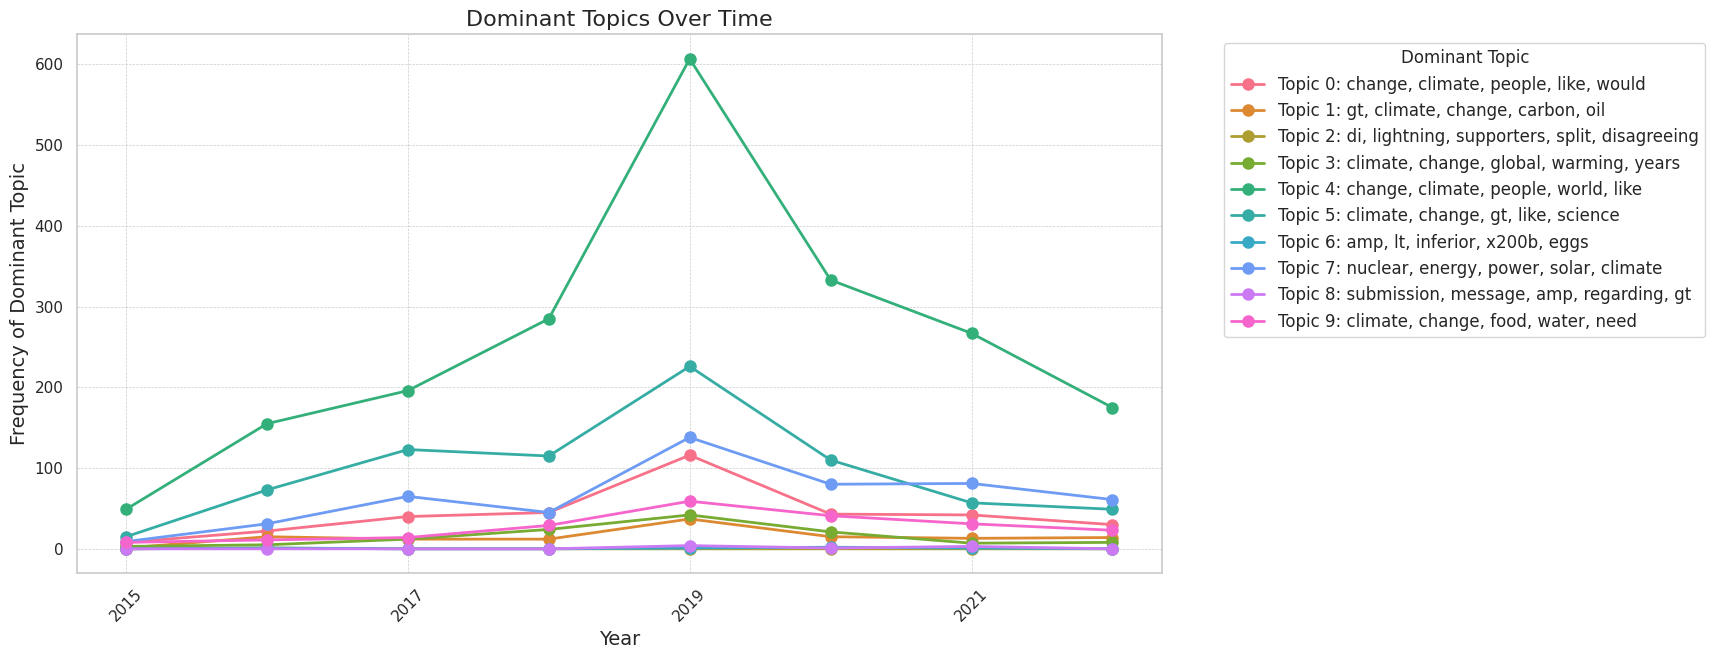

In [ ]:
analyze_topics_over_time(df_futurology, 'body', 'date', num_topics=10, passes=15, topn_words=5)

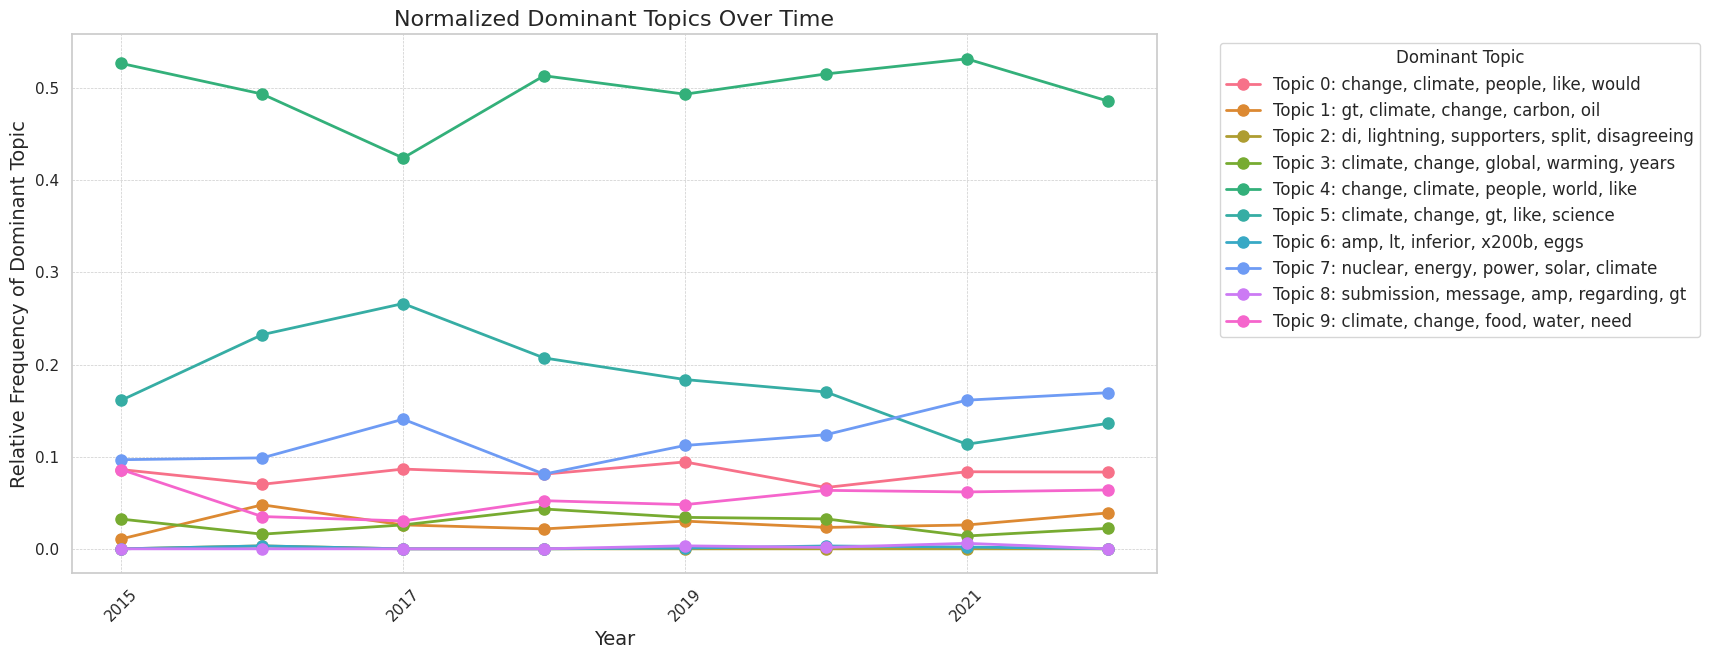

In [21]:
analyze_topics_over_time_normalized(df_futurology, 'body', 'date', num_topics=10, passes=15, topn_words=5)

In [8]:
def analyze_topics(df, text_column, date_column, num_topics=10, passes=15, topn_words=5, unit="year", normalized=False):
    # Tokenize and preprocess the documents
    df = df.sample(frac=0.05, random_state=42)
    stop_words = set(stopwords.words('english'))
    tokenized_documents = [word_tokenize(doc.lower()) for doc in df[text_column].tolist()]
    filtered_documents = [
        [word for word in doc if word.isalnum() and word not in stop_words and not re.match(r'https?://\S+|www\.\S+|http\S+', word)]
        for doc in tokenized_documents
    ]

    # Create a dictionary and corpus
    dictionary = corpora.Dictionary(filtered_documents)
    corpus = [dictionary.doc2bow(doc) for doc in filtered_documents]

    # Build the LDA model
    lda_model = gensim.models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=passes, random_state=42)

    # Find dominant topics and their top words
    dominant_topics = []
    for doc_bow in corpus:
        doc_topics = lda_model.get_document_topics(doc_bow, minimum_probability=0.0)
        dominant_topic = sorted(doc_topics, key=lambda x: x[1], reverse=True)[0][0]
        top_words = [word for word, prob in lda_model.show_topic(dominant_topic, topn=topn_words)]
        top_words_str = ", ".join(top_words)
        topic_and_words = f"Topic {dominant_topic}: {top_words_str}"
        dominant_topics.append(topic_and_words)

    df['dominant_topic'] = dominant_topics
    df[date_column] = pd.to_datetime(df[date_column])
    df.set_index(date_column, inplace=True)

    if unit == "year" and normalized == False:
    # Resample and plot
      topic_counts_by_year = df.groupby([pd.Grouper(freq='Y'), 'dominant_topic']).size().unstack(fill_value=0)
      sns.set_theme(style="whitegrid")
      palette = sns.color_palette("husl", len(topic_counts_by_year.columns))

      plt.figure(figsize=(14, 7))
      for idx, topic in enumerate(topic_counts_by_year.columns):
          plt.plot(topic_counts_by_year.index.year, topic_counts_by_year[topic], marker='o', linewidth=2, markersize=8, label=f'{topic}', color=palette[idx])

      plt.title('Dominant Topics Over Time', fontsize=16)
      plt.xlabel('Year', fontsize=14)
      plt.ylabel('Frequency of Dominant Topic', fontsize=14)
      plt.legend(title='Dominant Topic', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
      plt.xticks(topic_counts_by_year.index.year[::2], rotation=45)
      plt.grid(True, which='both', linestyle='--', linewidth=0.5)
      plt.show()

    elif unit == "year" and normalized == True:
      topic_counts_by_year = df.groupby([pd.Grouper(freq='Y'), 'dominant_topic']).size().unstack(fill_value=0)
      normalized_topic_counts = topic_counts_by_year.div(topic_counts_by_year.sum(axis=1), axis=0)

      # Plot the normalized frequencies
      sns.set_theme(style="whitegrid")
      palette = sns.color_palette("husl", len(normalized_topic_counts.columns))

      plt.figure(figsize=(14, 7))
      for idx, topic in enumerate(normalized_topic_counts.columns):
          plt.plot(normalized_topic_counts.index.year, normalized_topic_counts[topic], marker='o', linewidth=2, markersize=8, label=f'{topic}', color=palette[idx])

      plt.title('Normalized Dominant Topics Over Time', fontsize=16)
      plt.xlabel('Year', fontsize=14)
      plt.ylabel('Relative Frequency of Dominant Topic', fontsize=14)
      plt.legend(title='Dominant Topic', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
      plt.xticks(normalized_topic_counts.index.year[::2], rotation=45)
      plt.grid(True, which='both', linestyle='--', linewidth=0.5)
      plt.show()

    elif unit == "month" and normalized == False:
      topic_counts_by_month = df.groupby([pd.Grouper(freq='M'), 'dominant_topic']).size().unstack(fill_value=0)
      sns.set_theme(style="whitegrid")

      # Sum up the frequencies for each topic over all months
      topic_sums = topic_counts_by_month.sum()

      # Select the top 5 topics based on the sum of frequencies
      top_topics = topic_sums.nlargest(3).index

      # Filter the palette to include colors only for the top 5 topics
      top_palette = [sns.color_palette("husl", len(topic_counts_by_month.columns))[topic_counts_by_month.columns.get_loc(topic)] for topic in top_topics]

      plt.figure(figsize=(14, 7))

      # Plot each of the top 5 topics with its respective color
      for idx, topic in enumerate(top_topics):
          plt.plot(topic_counts_by_month.index, topic_counts_by_month[topic], linewidth=2, label=f'{topic}', color=top_palette[idx])

      # Set title and labels with appropriate font sizes
      plt.title('Top 3 Dominant Topics Over Time', fontsize=16)
      plt.xlabel('Year', fontsize=14)
      plt.ylabel('Frequency of Dominant Topic', fontsize=14)

      # Set legend outside the plot
      plt.legend(title='Dominant Topic', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)

      # Format the x-axis to show only the year and ensure labels don't overlap
      plt.xticks(rotation=45)
      plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
      plt.gca().xaxis.set_major_locator(mdates.YearLocator())

      # Add grid lines for better readability
      plt.grid(True, which='both', linestyle='--', linewidth=0.5)
      plt.tight_layout()
      plt.show()

    else:
      topic_counts_by_month = df.groupby([pd.Grouper(freq='M'), 'dominant_topic']).size().unstack(fill_value=0)
      normalized_topic_counts = topic_counts_by_month.div(topic_counts_by_month.sum(axis=1), axis=0)


      sns.set_theme(style="whitegrid")

      # Sum up the frequencies for each topic over all months
      topic_sums = normalized_topic_counts.sum()

      # Select the top 5 topics based on the sum of frequencies
      top_topics = topic_sums.nlargest(3).index

      # Filter the palette to include colors only for the top 5 topics
      top_palette = [sns.color_palette("husl", len(normalized_topic_counts.columns))[normalized_topic_counts.columns.get_loc(topic)] for topic in top_topics]

      plt.figure(figsize=(14, 7))

      # Plot each of the top 5 topics with its respective color
      for idx, topic in enumerate(top_topics):
          plt.plot(normalized_topic_counts.index, normalized_topic_counts[topic], linewidth=2, label=f'{topic}', color=top_palette[idx])

      # Set title and labels with appropriate font sizes
      plt.title('Top 3 Dominant Topics Over Time', fontsize=16)
      plt.xlabel('Year', fontsize=14)
      plt.ylabel('Frequency of Dominant Topic', fontsize=14)

      # Set legend outside the plot
      plt.legend(title='Dominant Topic', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)

      # Format the x-axis to show only the year and ensure labels don't overlap
      plt.xticks(rotation=45)
      plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
      plt.gca().xaxis.set_major_locator(mdates.YearLocator())

      # Add grid lines for better readability
      plt.grid(True, which='both', linestyle='--', linewidth=0.5)
      plt.tight_layout()

      plt.show()


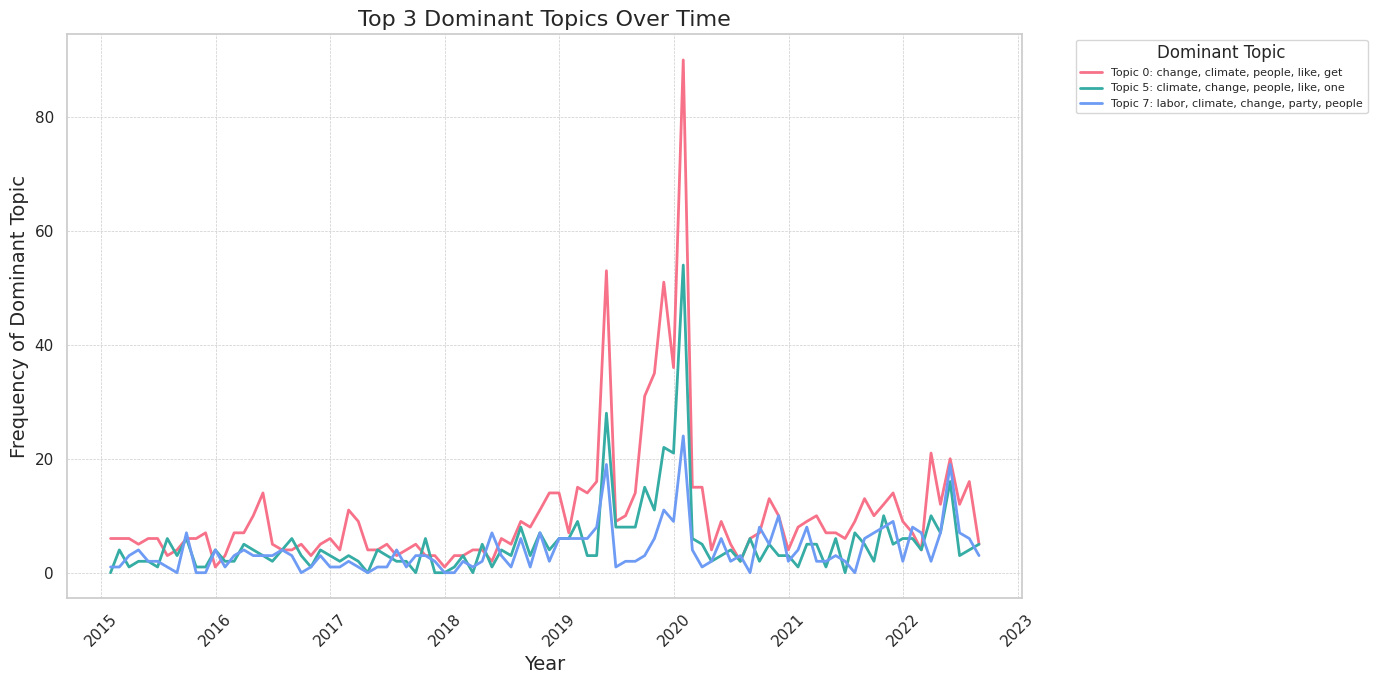

In [23]:
analyze_topics(df_australia, "body", "date", num_topics=10, passes=15, topn_words=5, unit="month", normalized=False)

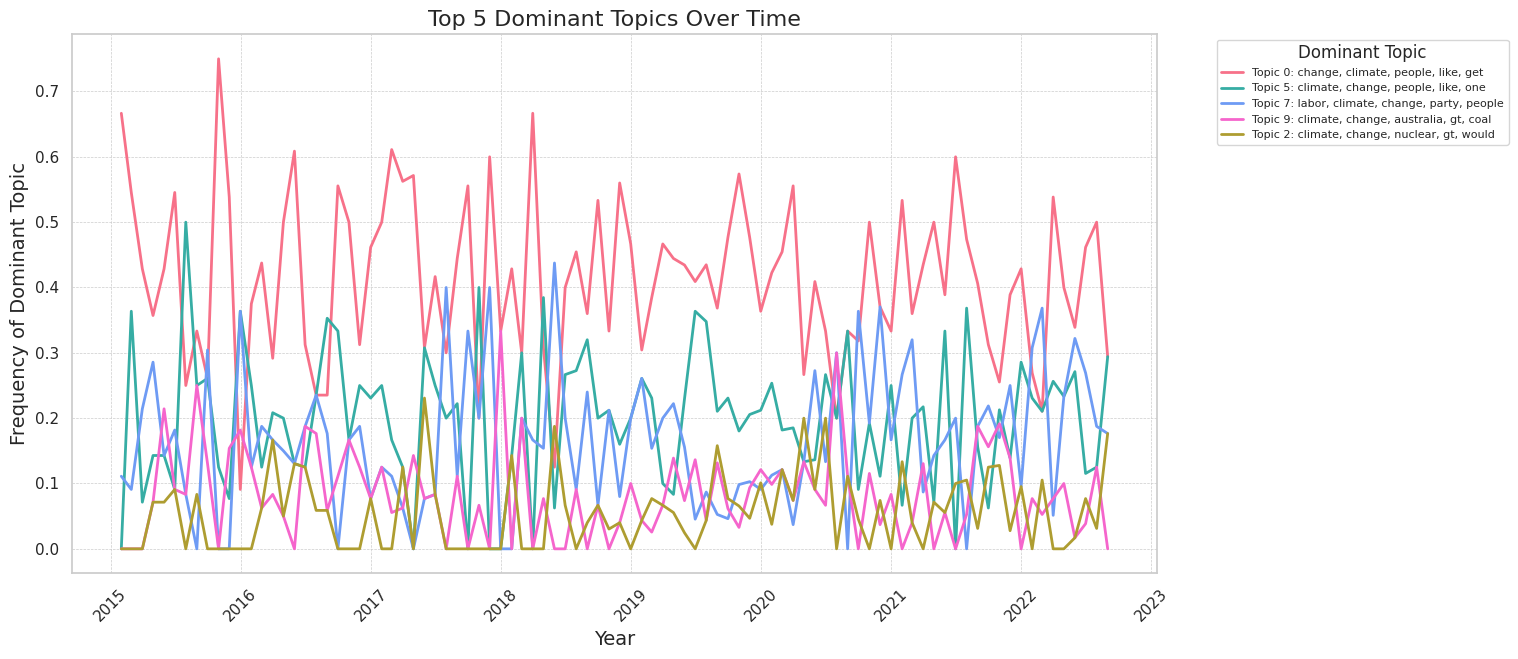

In [25]:
analyze_topics(df_australia, "body", "date", num_topics=10, passes=15, topn_words=5, unit="month", normalized=True)

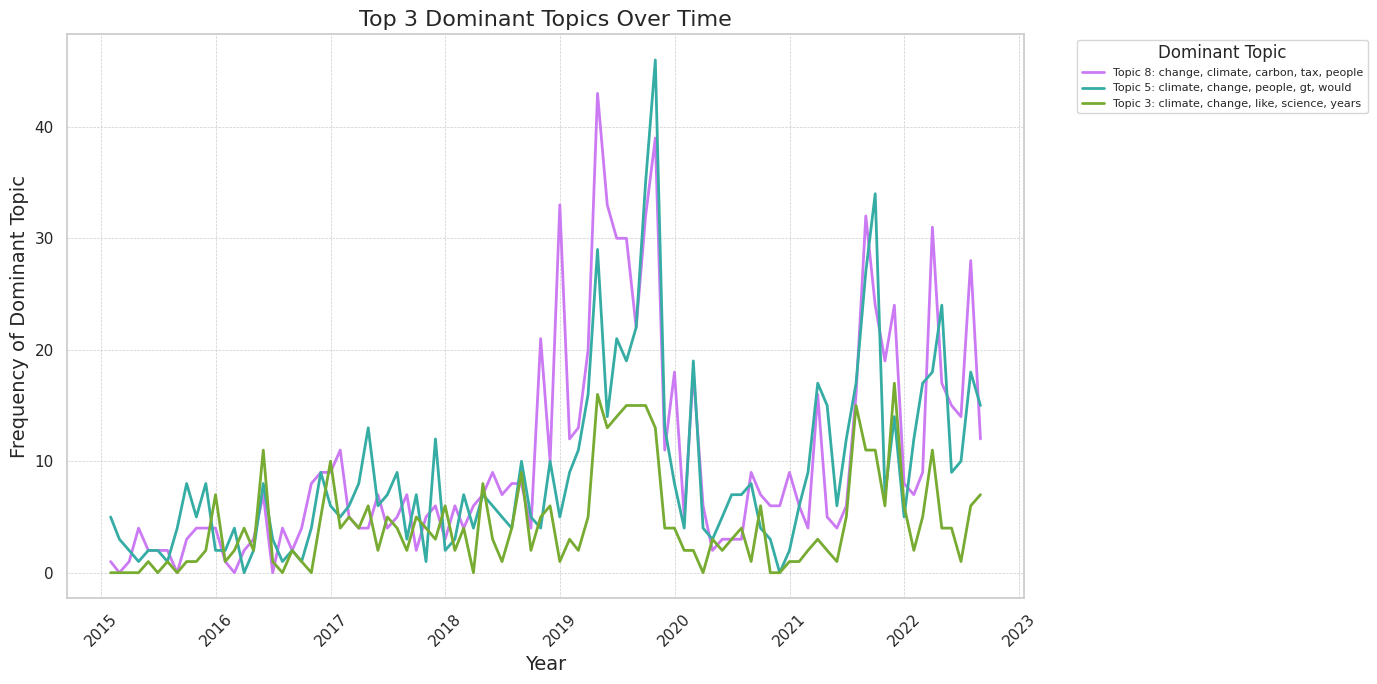

In [24]:
analyze_topics(df_canada, "body", "date", num_topics=10, passes=15, topn_words=5, unit="month", normalized=False)

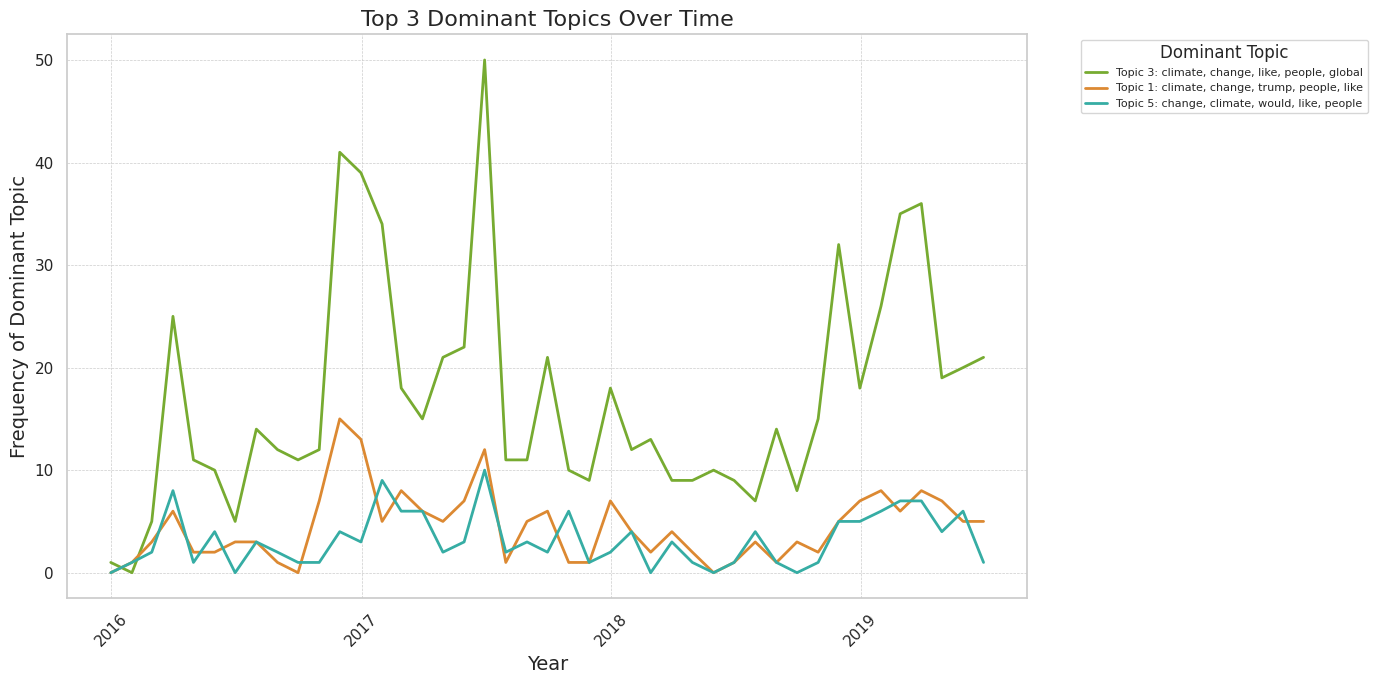

In [25]:
analyze_topics(df_donald, "body", "date", num_topics=10, passes=15, topn_words=5, unit="month", normalized=False)

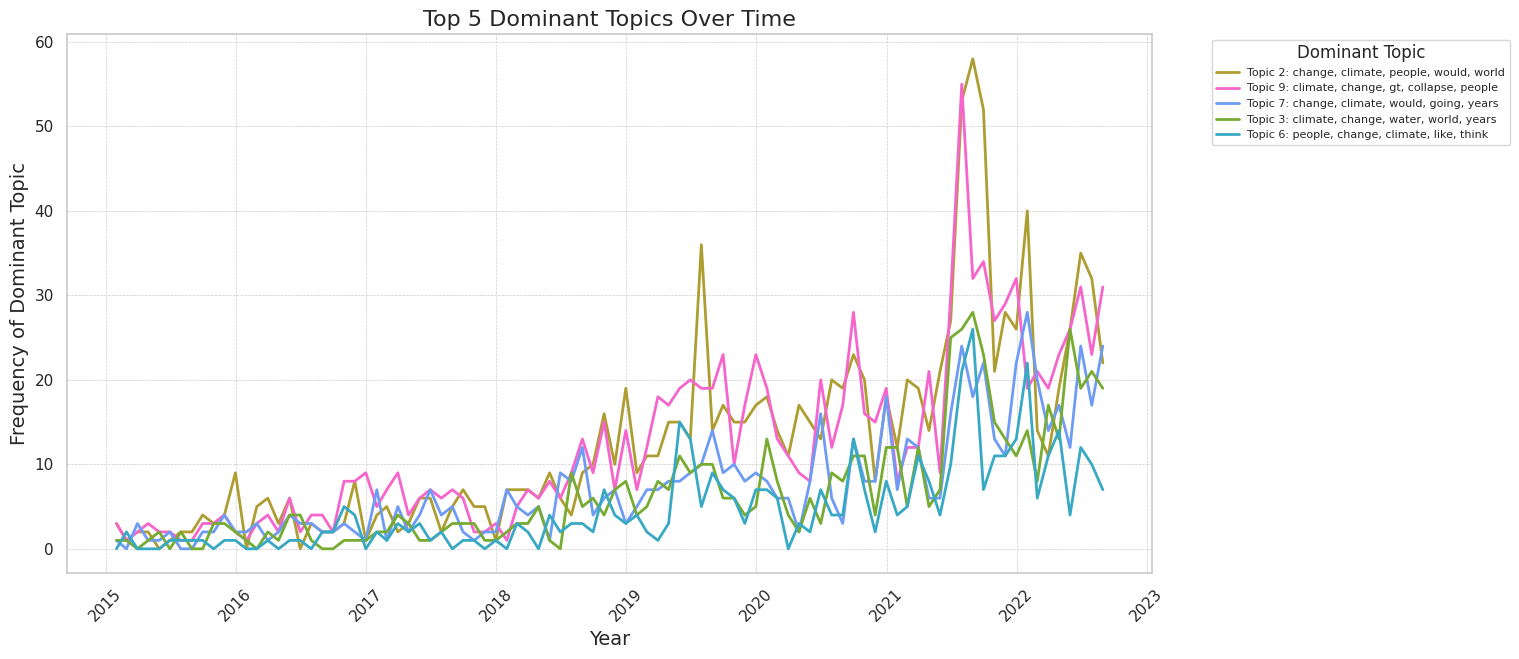

In [28]:
analyze_topics(df_collapse, "body", "date", num_topics=10, passes=15, topn_words=5, unit="month", normalized=False)

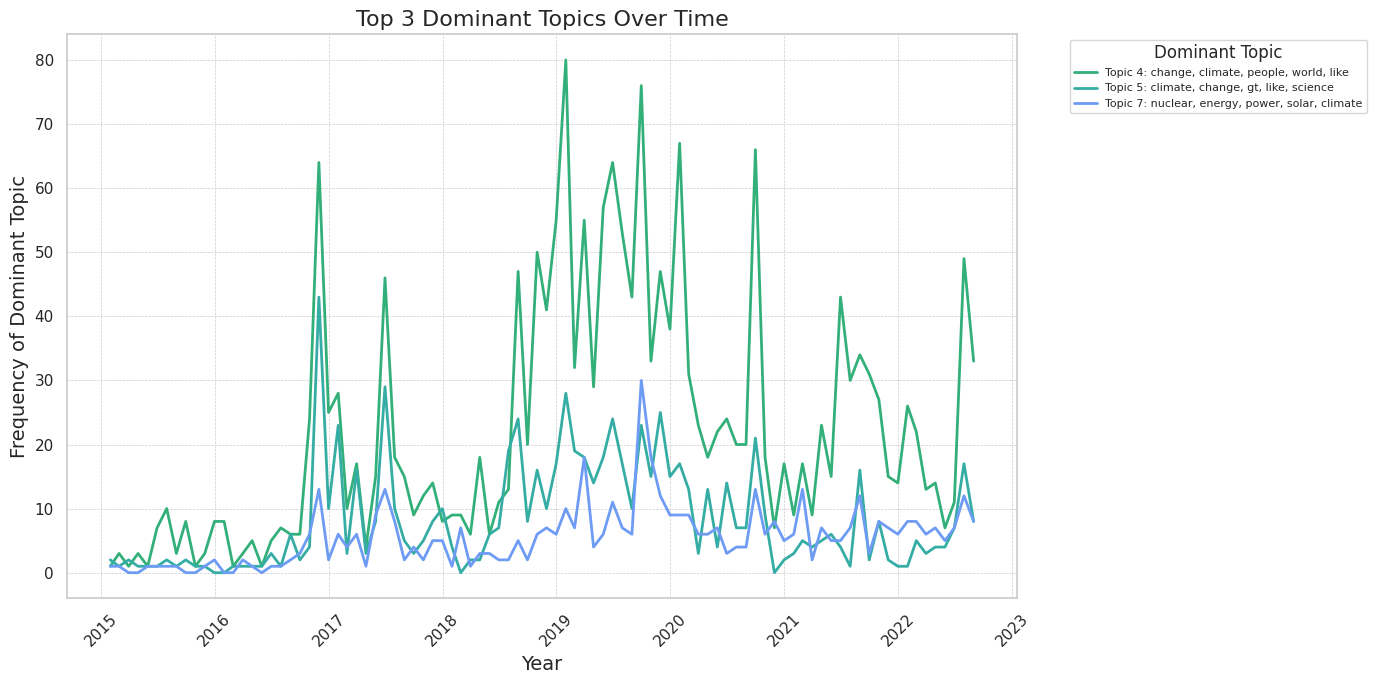

In [9]:
analyze_topics(df_futurology, "body", "date", num_topics=10, passes=15, topn_words=5, unit="month", normalized=False)